In [93]:
!pip install biopython
!pip install aaindex

In [94]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from sklearn.datasets import make_classification
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import Pipeline
from sklearn.svm import SVC
from sklearn.ensemble import RandomForestClassifier
from Bio.SeqUtils.ProtParam import ProteinAnalysis
from Bio.SeqUtils import ProtParamData
from aaindex import aaindex1
import warnings
warnings.filterwarnings('ignore')

In [95]:
complete_train = pd.read_csv("complete_train.tsv", sep='\t')

In [96]:
order = list("ARNDCQEGHILKMFPSTWYV")
aa_index = {}
for i, aa in enumerate(order):
  aa_index[aa]= i

print(aa_index)

{'A': 0, 'R': 1, 'N': 2, 'D': 3, 'C': 4, 'Q': 5, 'E': 6, 'G': 7, 'H': 8, 'I': 9, 'L': 10, 'K': 11, 'M': 12, 'F': 13, 'P': 14, 'S': 15, 'T': 16, 'W': 17, 'Y': 18, 'V': 19}


In [97]:
def aa_composition(sequence, length: int, aa_index):
  sequence = sequence[:length]
  freq = np.zeros((1, 20))
  for aa in sequence:
    if aa in aa_index.keys():
      freq[0, aa_index[aa]] += 1
  freq = np.round(freq/len(sequence), 3)
  return freq

aa_comp = np.vstack(complete_train['sequence'].apply(aa_composition, args=(22, aa_index)))
aa_comp

array([[0.182, 0.   , 0.   , ..., 0.136, 0.136, 0.045],
       [0.045, 0.   , 0.   , ..., 0.045, 0.045, 0.091],
       [0.182, 0.045, 0.   , ..., 0.   , 0.   , 0.136],
       ...,
       [0.091, 0.   , 0.045, ..., 0.   , 0.   , 0.045],
       [0.   , 0.136, 0.045, ..., 0.   , 0.   , 0.136],
       [0.045, 0.091, 0.   , ..., 0.   , 0.   , 0.136]])

In [98]:
def hydrophobicity(sequence, window: int, length: int):
    sequence = sequence[:length]
    seq = ProteinAnalysis(sequence)
    kd_pos = seq.protein_scale(ProtParamData.kd,window)
    d = int(window/2)
    sequence_with_padding = "X"*d + sequence + "X"*d
    seq_padding = ProteinAnalysis(sequence_with_padding)
    kd_pos_with_padding = seq_padding.protein_scale(ProtParamData.kd, window)
    return kd_pos_with_padding

hydro = np.vstack(complete_train['sequence'].apply(hydrophobicity, args=(5,40)))

Output streaming troncato alle ultime 5000 righe.


In [99]:
feature_codes = {
    "net_charge": ("KLEP840101", 2),
    "hydrophilicity": ("HOPT810101", 5),
    "helix_propensity": ("CHAM830101",7),
    "flexibility": ("BHAR880101", 7),
    "isoelectric_point": ("ZIMJ680104", 2),
    "bulkiness": ("ZIMJ680102", 7)
}

def features(sequence, length: int, feature_code, window: int):
  sequence = sequence[:length]
  seq = ProteinAnalysis(sequence)
  vals = aaindex1[feature_code].values
  val = seq.protein_scale(vals,window)
  mean = np.mean(val)
  std = np.std(val)
  max = np.max(val)
  return np.round([mean, std, max], 3)

feats = {}
for feature in feature_codes.keys():
  feats[feature] = np.vstack(complete_train['sequence'].apply(features, args=(30, feature_codes[feature][0], feature_codes[feature][1])))

np.savez('separate_features.npz', aa_comp = aa_comp, hydrophobicity = hydro, **feats)

In [100]:
extracted_features = np.load("separate_features.npz")
# Create a dictionary from the loaded features, handling multi-dimensional arrays
data = {}
for key in extracted_features.files:
    arr = extracted_features[key]
    if arr.ndim > 1:
        # If the array is multi-dimensional, create multiple columns
        for i in range(arr.shape[1]):
            data[f'{key}_{i+1}'] = arr[:, i]
    else:
        # If the array is 1-dimensional, use it directly
        data[key] = arr

X = pd.DataFrame(data)

In [101]:
y =complete_train['sp_type']
X.head()


,aa_comp_1,aa_comp_2,aa_comp_3,aa_comp_4,aa_comp_5,aa_comp_6,aa_comp_7,aa_comp_8,aa_comp_9,aa_comp_10,...,helix_propensity_3,flexibility_1,flexibility_2,flexibility_3,isoelectric_point_1,isoelectric_point_2,isoelectric_point_3,bulkiness_1,bulkiness_2,bulkiness_3
0,0.182,0.000,0.0,0.000,0.136,0.091,0.000,0.000,0.0,0.000,...,1.333,0.410,0.046,0.499,5.844,0.744,9.163,15.949,2.369,20.414
1,0.045,0.000,0.0,0.045,0.091,0.000,0.000,0.091,0.0,0.000,...,1.354,0.427,0.043,0.512,5.919,0.862,8.487,14.830,2.777,18.876
2,0.182,0.045,0.0,0.000,0.000,0.000,0.000,0.045,0.0,0.045,...,1.223,0.411,0.029,0.469,6.202,0.890,9.167,16.859,0.937,18.960
3,0.091,0.045,0.0,0.000,0.045,0.000,0.000,0.000,0.0,0.045,...,1.209,0.410,0.027,0.488,6.171,1.044,9.000,16.351,2.594,20.339
4,0.136,0.000,0.0,0.000,0.045,0.000,0.045,0.091,0.0,0.045,...,1.159,0.403,0.026,0.458,5.952,0.680,8.593,16.017,2.508,20.644


In [102]:
X_train, X_temp, y_train, y_temp = train_test_split(X, y, train_size=0.6, shuffle=True, random_state=42)
X_val, X_test, y_val, y_test = train_test_split(X_temp, y_temp, test_size=0.5, shuffle=True, random_state=42)

print(f"Training set shape: {X_train.shape}")
print(f"Validation set shape: {X_val.shape}")
print(f"Test set shape: {X_test.shape}")

Training set shape: (4812, 78)
Validation set shape: (1604, 78)
Test set shape: (1605, 78)


In [103]:
# We'll use a simple StandardScaler + RBF SVM pipeline
def svm_pipeline(C, gamma):
    return Pipeline([
        ("scaler", StandardScaler()),
        ("svm", SVC(kernel="rbf", C=C, gamma=gamma, random_state=42))
    ])

# Minimal manual grid
C_grid = [0.1, 1.0, 10.0, 100.0]
gamma_grid = ["scale", 0.01, 0.1, 1.0]

best_score_base = -np.inf
best_params_base = None

for C in C_grid:
    for gamma in gamma_grid:
        pipe = svm_pipeline(C, gamma)
        pipe.fit(X_train, y_train)                 # fit on TRAIN
        val_acc = pipe.score(X_val, y_val)         # evaluate on VALIDATION
        if val_acc > best_score_base:
            best_score_base = val_acc
            best_params_base = {"C": C, "gamma": gamma}

print("Baseline SVM (all features) — best validation accuracy: "
      f"{best_score_base:.3f} with params {best_params_base}")

Baseline SVM (all features) — best validation accuracy: 0.979 with params {'C': 10.0, 'gamma': 'scale'}


Top 10 features by Gini importance:
             feature  importance
0   hydrophilicity_1    0.073577
1  hydrophobicity_10    0.070503
2  hydrophobicity_12    0.065790
3  hydrophobicity_11    0.065467
4   hydrophobicity_9    0.057316
5  hydrophobicity_13    0.054797
6        bulkiness_3    0.041753
7   hydrophobicity_8    0.041364
8  hydrophobicity_14    0.039165
9      flexibility_1    0.036900


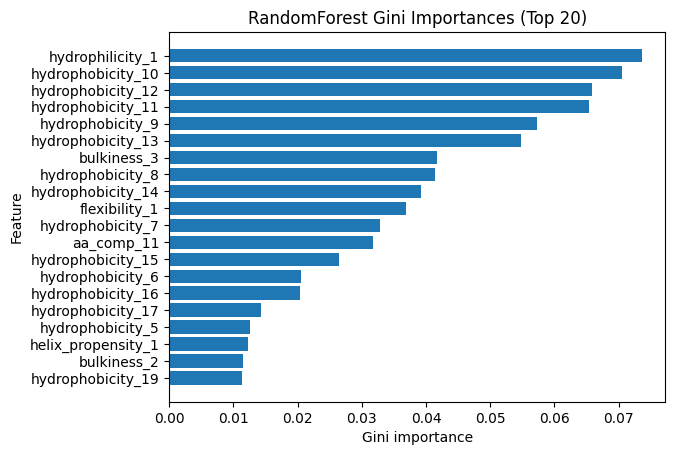

In [104]:
rf = RandomForestClassifier(
    n_estimators=400,
    random_state=42,
    n_jobs=-1
)
rf.fit(X_train, y_train)  # fit only on TRAIN

gini_imp = pd.Series(rf.feature_importances_, index=list(data.keys())).sort_values(ascending=False)
gini_df = gini_imp.reset_index()
gini_df.columns = ["feature", "importance"]
print("Top 10 features by Gini importance:")
print(gini_df.head(10))

# Plot top 20
plt.figure()
plt.barh(gini_df["feature"].head(20)[::-1], gini_df["importance"].head(20)[::-1])
plt.xlabel("Gini importance")
plt.ylabel("Feature")
plt.title("RandomForest Gini Importances (Top 20)")
plt.savefig("gini_rf.png")
plt.show()

Best k on validation (using baseline best params): k=15, val_acc=0.968


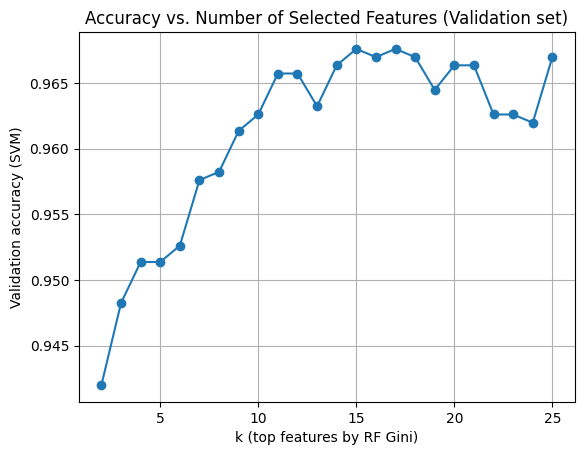

In [105]:
def accuracy_on_subset(C, gamma, subset_features):
    # subset by feature names
    # Convert data keys to a NumPy array for use with np.where
    data_keys_np = np.array(list(data.keys()))
    idx = [np.where(data_keys_np == f)[0][0] for f in subset_features]
    Xtr = X_train.iloc[:, idx]
    Xva = X_val.iloc[:, idx]
    pipe = svm_pipeline(C, gamma)
    pipe.fit(Xtr, y_train)     # train on TRAIN only
    return pipe.score(Xva, y_val)  # accuracy on VALIDATION

# We'll sweep k and, for each k, re-evaluate the best baseline SVM params on the reduced feature set
ks = list(range(2, min(26, X_train.shape[1]+1)))  # keep it small for speed/clarity
curve = []

for k in ks:
    subset = gini_df["feature"].head(k).tolist()
    acc_k = accuracy_on_subset(best_params_base["C"], best_params_base["gamma"], subset)
    curve.append(acc_k)

best_k_idx = int(np.argmax(curve))
best_k = ks[best_k_idx]
print(f"Best k on validation (using baseline best params): k={best_k}, val_acc={curve[best_k_idx]:.3f}")

plt.figure()
plt.plot(ks, curve, marker="o")
plt.xlabel("k (top features by RF Gini)")
plt.ylabel("Validation accuracy (SVM)")
plt.title("Accuracy vs. Number of Selected Features (Validation set)")
plt.grid(True)
plt.savefig("accuracy_vs_k.png")
plt.show()

In [106]:
# Use the best k from the validation curve
best_subset = gini_df["feature"].head(best_k).tolist()
data_keys_np = np.array(list(data.keys()))
idx = [np.where(data_keys_np == f)[0][0] for f in best_subset]

Xtr_sel = X_train.iloc[:, idx]
Xva_sel = X_val.iloc[:, idx]
Xte_sel = X_test.iloc[:, idx]

# Manual grid search again but now restricted to the selected features
best_score_sel = -np.inf
best_params_sel = None

for C in C_grid:
    for gamma in gamma_grid:
        pipe = svm_pipeline(C, gamma)
        pipe.fit(Xtr_sel, y_train)      # train on TRAIN
        val_acc = pipe.score(Xva_sel, y_val)  # validate on VAL
        if val_acc > best_score_sel:
            best_score_sel = val_acc
            best_params_sel = {"C": C, "gamma": gamma}

# Train final model on TRAIN+VAL with best params (optional) or just TRAIN; here we keep TRAIN only as per your outline
final_pipe = svm_pipeline(best_params_sel["C"], best_params_sel["gamma"])
final_pipe.fit(Xtr_sel, y_train)
test_acc = final_pipe.score(Xte_sel, y_test)


print("Selected features (best k):", best_subset)
print("Best validation accuracy on selected features:", f"{best_score_sel:.3f}", "with", best_params_sel)
print("Test accuracy (selected features, tuned on val):", f"{test_acc:.3f}")

# For comparison: test accuracy with all features using baseline best params
baseline_pipe = svm_pipeline(best_params_base["C"], best_params_base["gamma"])
baseline_pipe.fit(X_train, y_train)
test_acc_all = baseline_pipe.score(X_test, y_test)
print("Test accuracy (all features, baseline tuned on val):", f"{test_acc_all:.3f}")

Selected features (best k): ['hydrophilicity_1', 'hydrophobicity_10', 'hydrophobicity_12', 'hydrophobicity_11', 'hydrophobicity_9', 'hydrophobicity_13', 'bulkiness_3', 'hydrophobicity_8', 'hydrophobicity_14', 'flexibility_1', 'hydrophobicity_7', 'aa_comp_11', 'hydrophobicity_15', 'hydrophobicity_6', 'hydrophobicity_16']
Best validation accuracy on selected features: 0.968 with {'C': 10.0, 'gamma': 'scale'}
Test accuracy (selected features, tuned on val): 0.968
Test accuracy (all features, baseline tuned on val): 0.976
